In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.random import default_rng

from advanced_particle_filter.models.range_bearing import make_range_bearing_ssm
from advanced_particle_filter.filters.kalman import ExtendedKalmanFilter, UnscentedKalmanFilter
from advanced_particle_filter.filters.particle import BootstrapParticleFilter


In [3]:
# EKF/UKF Analysis - Normal Case
def run_ekf_ukf_comparison(m0_pos=(1.0, 0.5), T=200, seed=42):
    """
    Run EKF and UKF on Range-Bearing model.
    """
    rng = default_rng(seed)

    # Parameters
    dt = 0.01
    q_diag = 0.01
    nu = 2.0
    s_r = 0.01
    s_th = 0.01
    m0_tuple = (m0_pos[0], m0_pos[1], 0.01, 0.01)
    P0_diag_tuple = (0.1, 0.1, 0.1, 0.1)

    # Build model & simulate
    model = make_range_bearing_ssm(
        dt=dt, q_diag=q_diag, nu=nu, s_r=s_r, s_th=s_th,
        m0=m0_tuple, P0_diag=P0_diag_tuple
    )
    xs_true, ys = model.simulate(T, rng)

    # Run EKF
    ekf = ExtendedKalmanFilter()
    result_ekf = ekf.filter(model, ys)
    ms_ekf = result_ekf.means
    Ps_ekf = result_ekf.covariances

    # Run UKF
    ukf = UnscentedKalmanFilter()
    result_ukf = ukf.filter(model, ys)
    ms_ukf = result_ukf.means
    Ps_ukf = result_ukf.covariances

    return {
        'xs_true': xs_true,
        'ys': ys,
        'ms_ekf': ms_ekf,
        'Ps_ekf': Ps_ekf,
        'ms_ukf': ms_ukf,
        'Ps_ukf': Ps_ukf,
        'm0_pos': m0_pos,
        'model': model,
    }


# Normal case: target starts at (1.0, 0.5)
print("="*60)
print("Normal Case: Initial position (1.0, 0.5)")
print("="*60)

results_normal = run_ekf_ukf_comparison(m0_pos=(1.0, 0.5), T=200, seed=42)

# Compute RMSE
rmse_ekf = np.sqrt(np.mean((results_normal['ms_ekf'] - results_normal['xs_true'])**2))
rmse_ukf = np.sqrt(np.mean((results_normal['ms_ukf'] - results_normal['xs_true'])**2))

print(f"EKF RMSE (total): {rmse_ekf:.4f}")
print(f"UKF RMSE (total): {rmse_ukf:.4f}")


Normal Case: Initial position (1.0, 0.5)
EKF RMSE (total): 0.4762
UKF RMSE (total): 0.4752


In [4]:
# EKF/UKF Failure Mode - Singularity

print("="*60)
print("Failure Case: Initial position (0.01, 0.01) - Near Origin")
print("="*60)

results_failure = run_ekf_ukf_comparison(m0_pos=(0.01, 0.01), T=200, seed=42)

rmse_ekf_fail = np.sqrt(np.mean((results_failure['ms_ekf'] - results_failure['xs_true'])**2))
rmse_ukf_fail = np.sqrt(np.mean((results_failure['ms_ukf'] - results_failure['xs_true'])**2))

print(f"EKF RMSE (total): {rmse_ekf_fail:.4f}")
print(f"UKF RMSE (total): {rmse_ukf_fail:.4f}")


Failure Case: Initial position (0.01, 0.01) - Near Origin
EKF RMSE (total): 0.8778
UKF RMSE (total): 0.9686


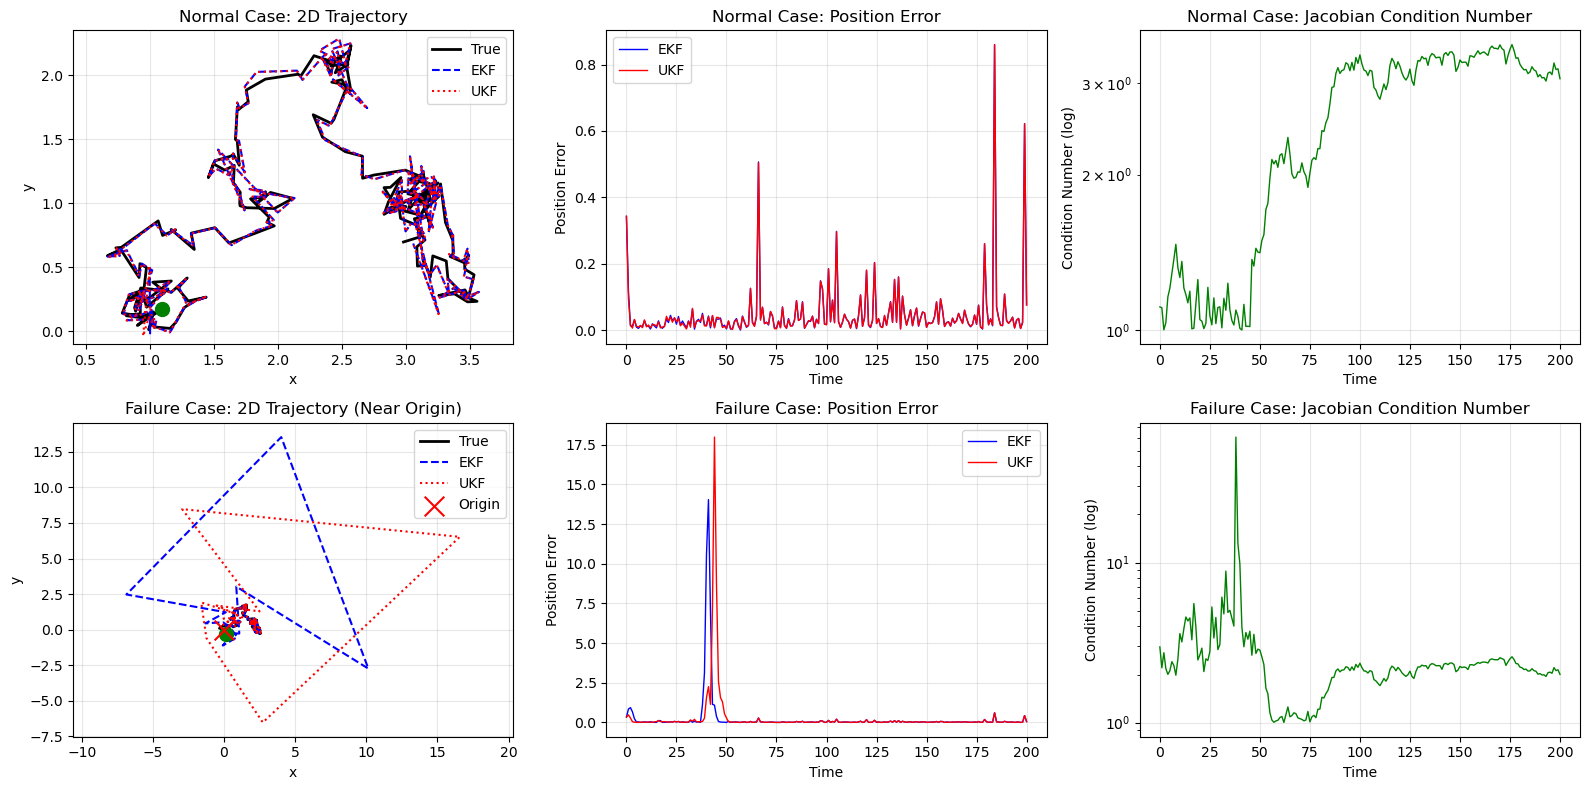

In [6]:
def plot_ekf_ukf_comparison(results_normal, results_failure):
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    
    # --- Normal Case ---
    xs_n = results_normal['xs_true']
    ms_ekf_n = results_normal['ms_ekf']
    ms_ukf_n = results_normal['ms_ukf']
    
    # Trajectory
    ax = axes[0, 0]
    ax.plot(xs_n[:, 0], xs_n[:, 1], 'k-', lw=2, label='True')
    ax.plot(ms_ekf_n[:, 0], ms_ekf_n[:, 1], 'b--', lw=1.5, label='EKF')
    ax.plot(ms_ukf_n[:, 0], ms_ukf_n[:, 1], 'r:', lw=1.5, label='UKF')
    ax.scatter(xs_n[0, 0], xs_n[0, 1], c='g', s=100, marker='o', zorder=5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Normal Case: 2D Trajectory')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    # Position error over time
    ax = axes[0, 1]
    t = np.arange(len(xs_n))
    err_ekf_n = np.sqrt(np.sum((ms_ekf_n[:, :2] - xs_n[:, :2])**2, axis=1))
    err_ukf_n = np.sqrt(np.sum((ms_ukf_n[:, :2] - xs_n[:, :2])**2, axis=1))
    ax.plot(t, err_ekf_n, 'b-', lw=1, label='EKF')
    ax.plot(t, err_ukf_n, 'r-', lw=1, label='UKF')
    ax.set_xlabel('Time')
    ax.set_ylabel('Position Error')
    ax.set_title('Normal Case: Position Error')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Jacobian condition number (for EKF)
    ax = axes[0, 2]
    cond_numbers = []
    for i in range(len(xs_n)):
        px, py = xs_n[i, 0], xs_n[i, 1]
        r2 = px**2 + py**2 + 1e-12
        r = np.sqrt(r2)
        H = np.array([
            [px/r, py/r, 0, 0],
            [-py/r2, px/r2, 0, 0]
        ])
        cond_numbers.append(np.linalg.cond(H))
    ax.semilogy(t, cond_numbers, 'g-', lw=1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Condition Number (log)')
    ax.set_title('Normal Case: Jacobian Condition Number')
    ax.grid(True, alpha=0.3)
    
    # --- Failure Case ---
    xs_f = results_failure['xs_true']
    ms_ekf_f = results_failure['ms_ekf']
    ms_ukf_f = results_failure['ms_ukf']
    
    # Trajectory
    ax = axes[1, 0]
    ax.plot(xs_f[:, 0], xs_f[:, 1], 'k-', lw=2, label='True')
    if np.all(np.isfinite(ms_ekf_f)):
        ax.plot(ms_ekf_f[:, 0], ms_ekf_f[:, 1], 'b--', lw=1.5, label='EKF')
    if np.all(np.isfinite(ms_ukf_f)):
        ax.plot(ms_ukf_f[:, 0], ms_ukf_f[:, 1], 'r:', lw=1.5, label='UKF')
    ax.scatter(xs_f[0, 0], xs_f[0, 1], c='g', s=100, marker='o', zorder=5)
    ax.scatter(0, 0, c='red', s=200, marker='x', zorder=5, label='Origin')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Failure Case: 2D Trajectory (Near Origin)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    # Position error over time
    ax = axes[1, 1]
    t = np.arange(len(xs_f))
    if np.all(np.isfinite(ms_ekf_f)):
        err_ekf_f = np.sqrt(np.sum((ms_ekf_f[:, :2] - xs_f[:, :2])**2, axis=1))
        ax.plot(t, err_ekf_f, 'b-', lw=1, label='EKF')
    if np.all(np.isfinite(ms_ukf_f)):
        err_ukf_f = np.sqrt(np.sum((ms_ukf_f[:, :2] - xs_f[:, :2])**2, axis=1))
        ax.plot(t, err_ukf_f, 'r-', lw=1, label='UKF')
    ax.set_xlabel('Time')
    ax.set_ylabel('Position Error')
    ax.set_title('Failure Case: Position Error')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Jacobian condition number
    ax = axes[1, 2]
    cond_numbers_f = []
    for i in range(len(xs_f)):
        px, py = xs_f[i, 0], xs_f[i, 1]
        r2 = px**2 + py**2 + 1e-12
        r = np.sqrt(r2)
        H = np.array([
            [px/r, py/r, 0, 0],
            [-py/r2, px/r2, 0, 0]
        ])
        cond_numbers_f.append(np.linalg.cond(H))
    ax.semilogy(t, cond_numbers_f, 'g-', lw=1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Condition Number (log)')
    ax.set_title('Failure Case: Jacobian Condition Number')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_ekf_ukf_comparison(results_normal, results_failure)

In [7]:
# Particle Filter Degeneracy Analysis

def run_pf_with_diagnostics(T=200, num_particles=1000, seed=42):
    rng = default_rng(seed)

    # Parameters matching EKF/UKF tests
    dt = 0.01
    q_diag = 0.01
    nu = 2.0
    s_r = 0.01
    s_th = 0.01
    m0_tuple = (1.0, 0.5, 0.01, 0.01)
    P0_diag_tuple = (0.1, 0.1, 0.1, 0.1)

    model = make_range_bearing_ssm(
        dt=dt, q_diag=q_diag, nu=nu, s_r=s_r, s_th=s_th,
        m0=m0_tuple, P0_diag=P0_diag_tuple
    )
    xs_true, ys = model.simulate(T, rng)

    # Run PF with NO resampling to show degeneracy
    pf = BootstrapParticleFilter(
        n_particles=num_particles,
        resample_criterion='never',
        seed=seed + 1,
    )
    result = pf.filter(model, ys, return_particles=True)

    return {
        'xs_true': xs_true,
        'ys': ys,
        'ms_pf': result.means,
        'Ps_pf': result.covariances,
        'info': {
            'ess': result.ess,
            'weights': result.weights,
            'particles': result.particles,
            'resampled': result.resampled,
        },
        'num_particles': num_particles,
    }


# Run PF
print("Running Particle Filter with diagnostics...")
pf_results = run_pf_with_diagnostics(T=500, num_particles=1000, seed=42)

print(f"Avg ESS: {np.mean(pf_results['info']['ess']):.1f} / {pf_results['num_particles']}")
print(f"Avg ESS ratio: {np.mean(pf_results['info']['ess']) / pf_results['num_particles']:.3f}")
print(f"Min ESS: {np.min(pf_results['info']['ess']):.1f}")
print(f"Resample count: {np.sum(pf_results['info']['resampled'])} / {len(pf_results['info']['resampled'])}")


Running Particle Filter with diagnostics...
Avg ESS: 1.0 / 1000
Avg ESS ratio: 0.001
Min ESS: 1.0
Resample count: 0 / 500


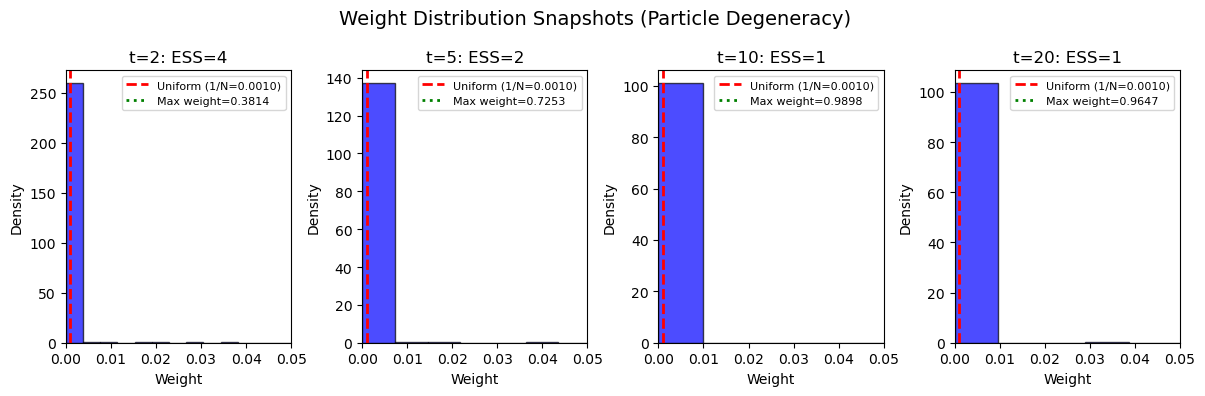

In [29]:
# Weight Histogram Snapshots
def plot_weight_histograms(pf_results, time_points=[10, 50, 100, 200]):
    weights = pf_results['info']['weights']  # [T+1, N]
    N = pf_results['num_particles']
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    axes = axes.flatten()
    
    for idx, t in enumerate(time_points):
        ax = axes[idx]
        w = weights[t]  # [N]
        
        # Remove very small weights for visualization
        # w_nonzero = w[w > 1e-10]
        
        ax.hist(w, bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
        ax.axvline(1/N, color='r', ls='--', lw=2, label=f'Uniform (1/N={1/N:.4f})')
        ax.axvline(np.max(w), color='g', ls=':', lw=2, label=f'Max weight={np.max(w):.4f}')
        
        # Statistics
        ess = 1.0 / np.sum(w**2)
        
        ax.set_xlabel('Weight')
        ax.set_ylabel('Density')
        ax.set_title(f't={t}: ESS={ess:.0f}')
        ax.legend(fontsize=8)
        ax.set_xlim([0, min(0.05, np.max(w)*1.1)])
    
    plt.suptitle('Weight Distribution Snapshots (Particle Degeneracy)', fontsize=14)
    plt.tight_layout()
    plt.show()


plot_weight_histograms(pf_results, time_points=[2,5,10,20])

In [11]:
# =============================================================================
# Part (d): Metrics Computation Functions
# =============================================================================

def compute_rmse(estimates, true_states):
    """Root Mean Square Error."""
    return np.sqrt(np.mean((estimates - true_states)**2))


def compute_mae(estimates, true_states):
    """Mean Absolute Error."""
    return np.mean(np.abs(estimates - true_states))


def compute_coverage_90(estimates, covariances, true_states):
    """
    Compute 90 percent credible interval coverage.
    """
    T_plus_1, nx = estimates.shape
    
    in_interval = 0
    total = 0
    
    for t in range(T_plus_1):
        for d in range(nx):
            mean = estimates[t, d]
            std = np.sqrt(covariances[t, d, d])
            lower = mean - 1.645 * std
            upper = mean + 1.645 * std
            
            if lower <= true_states[t, d] <= upper:
                in_interval += 1
            total += 1
    
    return in_interval / total


def compute_coverage_90_particles(particles, weights, true_states):
    """
    Compute 90 percent credible interval coverage using particle quantiles.
    """
    T_plus_1, N, nx = particles.shape
    
    in_interval = 0
    total = 0
    
    for t in range(T_plus_1):
        for d in range(nx):
            # Sort particles by value in dimension d
            vals = particles[t, :, d]
            w = weights[t]
            
            # Weighted quantiles
            sorted_idx = np.argsort(vals)
            sorted_vals = vals[sorted_idx]
            sorted_weights = w[sorted_idx]
            
            cum_weights = np.cumsum(sorted_weights)
            cum_weights /= cum_weights[-1]  # Normalize
            
            # Find 5th and 95th percentiles
            lower_idx = np.searchsorted(cum_weights, 0.05)
            upper_idx = np.searchsorted(cum_weights, 0.95)
            
            lower = sorted_vals[min(lower_idx, N-1)]
            upper = sorted_vals[min(upper_idx, N-1)]
            
            if lower <= true_states[t, d] <= upper:
                in_interval += 1
            total += 1
    
    return in_interval / total


def measure_runtime_memory(func, *args, **kwargs):
    """
    Measure runtime and memory usage of a function.
    Returns: result, runtime_sec, peak_memory_mb_tracemalloc, peak_memory_mb_psutil
    """
    process = psutil.Process()
    
    # Memory before
    mem_before = process.memory_info().rss
    
    # Tracemalloc
    tracemalloc.start()
    
    # Run and time
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    
    # Memory after
    current, peak_tracemalloc = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    mem_after = process.memory_info().rss
    
    runtime = end_time - start_time
    peak_mb_tracemalloc = peak_tracemalloc / (1024 * 1024)
    peak_mb_psutil = (mem_after - mem_before) / (1024 * 1024)
    
    return result, runtime, peak_mb_tracemalloc, max(0, peak_mb_psutil)

In [30]:
# Main comparison
import psutil
import tracemalloc

def comprehensive_comparison(T=200, num_particles_list=[500, 1000, 5000], seed=42):
    """
    Compare PF, EKF, and UKF on Range-Bearing model.
    """
    rng = default_rng(seed)

    # Parameters
    dt = 0.01
    q_diag = 0.01
    nu = 2.0
    s_r = 0.01
    s_th = 0.01
    m0_tuple = (1.0, 0.5, 0.01, 0.01)
    P0_diag_tuple = (0.1, 0.1, 0.1, 0.1)

    model = make_range_bearing_ssm(
        dt=dt, q_diag=q_diag, nu=nu, s_r=s_r, s_th=s_th,
        m0=m0_tuple, P0_diag=P0_diag_tuple
    )
    xs_true, ys = model.simulate(T, rng)

    results = []

    # --- EKF ---
    print("Running EKF...")
    def run_ekf():
        ekf = ExtendedKalmanFilter()
        return ekf.filter(model, ys)

    result_ekf, rt_ekf, mem_trace_ekf, mem_psutil_ekf = measure_runtime_memory(run_ekf)

    results.append({
        'method': 'EKF',
        'rmse': compute_rmse(result_ekf.means, xs_true),
        'mae': compute_mae(result_ekf.means, xs_true),
        'coverage_90': compute_coverage_90(result_ekf.means, result_ekf.covariances, xs_true),
        'loglik': result_ekf.log_likelihood if result_ekf.log_likelihood is not None else np.nan,
        'runtime': rt_ekf,
        'memory_tracemalloc': mem_trace_ekf,
        'memory_psutil': mem_psutil_ekf,
    })

    # --- UKF ---
    print("Running UKF...")
    def run_ukf():
        ukf = UnscentedKalmanFilter()
        return ukf.filter(model, ys)

    result_ukf, rt_ukf, mem_trace_ukf, mem_psutil_ukf = measure_runtime_memory(run_ukf)

    results.append({
        'method': 'UKF',
        'rmse': compute_rmse(result_ukf.means, xs_true),
        'mae': compute_mae(result_ukf.means, xs_true),
        'coverage_90': compute_coverage_90(result_ukf.means, result_ukf.covariances, xs_true),
        'loglik': result_ukf.log_likelihood if result_ukf.log_likelihood is not None else np.nan,
        'runtime': rt_ukf,
        'memory_tracemalloc': mem_trace_ukf,
        'memory_psutil': mem_psutil_ukf,
    })

    # --- PF with different particle counts ---
    for N in num_particles_list:
        print(f"Running PF (N={N})...")

        def run_pf(n=N):
            pf = BootstrapParticleFilter(
                n_particles=n,
                resample_criterion='ess',
                seed=seed + 1,
            )
            return pf.filter(model, ys, return_particles=True)

        result_pf, rt_pf, mem_trace_pf, mem_psutil_pf = measure_runtime_memory(run_pf)

        # Coverage using particles
        coverage = compute_coverage_90_particles(
            result_pf.particles, result_pf.weights, xs_true
        )

        results.append({
            'method': f'PF (N={N})',
            'rmse': compute_rmse(result_pf.means, xs_true),
            'mae': compute_mae(result_pf.means, xs_true),
            'coverage_90': coverage,
            'loglik': result_pf.log_likelihood,
            'runtime': rt_pf,
            'memory_tracemalloc': mem_trace_pf,
            'memory_psutil': mem_psutil_pf,
            'avg_ess': result_pf.average_ess(),
        })

    return results, xs_true, ys


# Run comparison
results, xs_true, ys = comprehensive_comparison(
    T=200, num_particles_list=[500, 2000, 10**5], seed=42
)


Running EKF...
Running UKF...
Running PF (N=500)...
Running PF (N=2000)...
Running PF (N=100000)...


In [31]:
def print_results_table(results):
    """Print comparison results as a formatted table."""
    
    print("\n" + "="*100)
    print("COMPREHENSIVE COMPARISON: Range-Bearing Model")
    print("="*100)
    
    # Header
    print(f"{'Method':<15} | {'RMSE':>8} | {'MAE':>8} | {'90% Cov':>8} | {'LogLik':>10} | {'Time(s)':>8} | {'Mem(MB)':>8}")
    print("-"*100)
    
    for r in results:
        loglik_str = f"{r['loglik']:.1f}" if not np.isnan(r['loglik']) else "N/A"
        mem = max(r['memory_tracemalloc'], r['memory_psutil'])
        
        print(f"{r['method']:<15} | {r['rmse']:>8.4f} | {r['mae']:>8.4f} | {r['coverage_90']:>8.2%} | {loglik_str:>10} | {r['runtime']:>8.3f} | {mem:>8.2f}")
    
    print("-"*100)
    
    # Additional PF info
    print("\nParticle Filter Details:")
    for r in results:
        if 'avg_ess' in r:
            print(f"  {r['method']}: Avg ESS = {r['avg_ess']:.1f}")


print_results_table(results)


COMPREHENSIVE COMPARISON: Range-Bearing Model
Method          |     RMSE |      MAE |  90% Cov |     LogLik |  Time(s) |  Mem(MB)
----------------------------------------------------------------------------------------------------
EKF             |   0.4762 |   0.2893 |   85.57% |      340.9 |    0.030 |     1.23
UKF             |   0.4752 |   0.2885 |   86.94% |      340.4 |    0.056 |     0.77
PF (N=500)      |   0.7095 |   0.4111 |   62.81% |      438.9 |    0.123 |     9.77
PF (N=2000)     |   0.6121 |   0.3714 |   66.79% |      451.7 |    0.200 |    17.94
PF (N=100000)   |   0.4177 |   0.2533 |   92.04% |      459.5 |    6.286 |   787.78
----------------------------------------------------------------------------------------------------

Particle Filter Details:
  PF (N=500): Avg ESS = 19.5
  PF (N=2000): Avg ESS = 72.4
  PF (N=100000): Avg ESS = 3594.6
